In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('finalized_county.csv')

In [3]:
data.head()

,Unnamed: 0,date,county,state,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,...,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective,entity,incremental_cases
0,190,2020-03-10,Los Angeles,California,20,0.0,no,no,34.358922,-118.217049,...,52.70,52.52,47.000000,46.10,46.60,43.573333,2020-03-19,2020-03-19,California-Los Angeles,1.0
1,201,2020-03-11,Los Angeles,California,28,1.0,no,no,34.358922,-118.217049,...,51.80,51.56,51.566667,48.14,46.69,44.326667,2020-03-19,2020-03-19,California-Los Angeles,8.0
2,213,2020-03-12,Los Angeles,California,32,1.0,no,no,34.358922,-118.217049,...,50.54,51.08,50.833333,51.54,46.19,44.380000,2020-03-19,2020-03-19,California-Los Angeles,4.0
3,225,2020-03-13,Los Angeles,California,40,1.0,no,no,34.358922,-118.217049,...,50.18,50.60,50.800000,49.76,45.43,44.306667,2020-03-19,2020-03-19,California-Los Angeles,8.0
4,237,2020-03-14,Los Angeles,California,53,1.0,no,no,34.358922,-118.217049,...,50.18,50.00,48.866667,48.06,45.90,44.380000,2020-03-19,2020-03-19,California-Los Angeles,13.0


In [4]:
data['entity'].unique()

array(['California-Los Angeles', 'California-Orange',
       'California-San Diego', 'Florida-Miami-Dade', 'Illinois-Cook',
       'Nevada-Clark', 'New York-Nassau', 'New York-New York City',
       'New York-Suffolk', 'Pennsylvania-Philadelphia', 'Texas-Harris',
       'Texas-Tarrant'], dtype=object)

In [5]:
tarrant = data[data['entity'] == 'Texas-Tarrant'].loc[:, ['date', 'incremental_cases']]

In [6]:
def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Tarrant data is non-stationary without any differencing
stationary_test(tarrant.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(0.797730554034858, 0.991599446459923)

In [7]:
# first-level differencing
tarrant['incremental_cases'] = tarrant['incremental_cases'].diff().fillna(tarrant['incremental_cases']).astype('int')

# tarrant is stationary after first-level differencing
stationary_test(tarrant.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-4.202227487486791, 0.0006532028881806257)

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

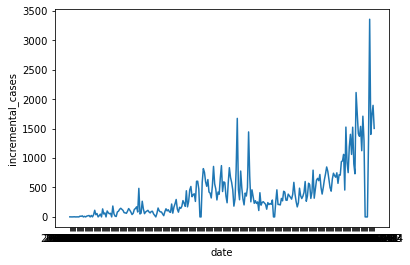

In [9]:
# use non-differenced cases for test actuals
# using differenced cases for train
train = tarrant.iloc[:230, :]
testing = data[data['entity'] == 'Texas-Tarrant'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [10]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

2569473.419238112 for parameters (0, 0, 0)
1381069.6361003642 for parameters (0, 0, 1)
14174678.407674938 for parameters (0, 0, 2)
832540.9870014527 for parameters (0, 0, 5)
1908402.5904258154 for parameters (0, 0, 10)
2801741024.85 for parameters (0, 1, 0)
2560540.476180624 for parameters (0, 1, 1)
1259742.8331533037 for parameters (0, 1, 2)
797566.9988461343 for parameters (0, 1, 5)
1263153.1931345072 for parameters (0, 1, 10)
106969943699.84996 for parameters (0, 2, 0)
3096174592.780471 for parameters (0, 2, 1)
5568262.043074178 for parameters (0, 2, 2)
11110265.07121401 for parameters (0, 2, 5)
37694442.61141221 for parameters (0, 2, 10)
2.5868946071213e+18 for parameters (0, 5, 0)
1.6572093375015184e+16 for parameters (0, 5, 1)
38090830306424.64 for parameters (0, 5, 2)
3921193351953.343 for parameters (0, 5, 5)
250072405481.1259 for parameters (0, 5, 10)
1380485.4629258858 for parameters (1, 0, 0)
3316658.6320265024 for parameters (1, 0, 1)
2700685.514175326 for parameters (1, 0,

In [19]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

1339559.223218605 for parameters (1, 1, 1)
2272959.232047419 for parameters (1, 1, 2)
2354763.3091720664 for parameters (1, 1, 3)
16678880.162999174 for parameters (1, 1, 4)
20323951.178500425 for parameters (1, 1, 5)
2347438723.428894 for parameters (1, 2, 1)
2826365.5938337417 for parameters (1, 2, 2)
9084340.135920348 for parameters (1, 2, 3)
27790160.08100053 for parameters (1, 2, 4)
11495456.47630347 for parameters (1, 2, 5)
320154950510.2367 for parameters (1, 3, 1)
2819966018.057811 for parameters (1, 3, 2)
10646872471.867283 for parameters (1, 3, 3)
59763917.51633513 for parameters (1, 3, 4)
20048009.795742385 for parameters (1, 3, 5)
502227558691.62616 for parameters (1, 4, 1)
398997680546.2494 for parameters (1, 4, 2)
13888823891.341742 for parameters (1, 4, 3)
6387196408.495573 for parameters (1, 4, 4)
43154046.445269965 for parameters (1, 4, 5)
1098813836439456.0 for parameters (1, 5, 1)
910627512557.5579 for parameters (1, 5, 2)
487929748932.953 for parameters (1, 5, 3)
2.

7757885.474847628 for parameters (8, 3, 5)
1099007915613.568 for parameters (8, 4, 1)
91454195.79923959 for parameters (8, 4, 2)
23319600.177841377 for parameters (8, 4, 3)
11589061.87805549 for parameters (8, 4, 4)
566511097.5644928 for parameters (8, 4, 5)
111855135859039.05 for parameters (8, 5, 1)
546556265739.38934 for parameters (8, 5, 2)
851142673030.6917 for parameters (8, 5, 3)
24659841076.37469 for parameters (8, 5, 4)
15450308.768216724 for parameters (8, 5, 5)
9177473.415488014 for parameters (9, 1, 1)
1973205.4098518756 for parameters (9, 1, 2)
6970180.456609977 for parameters (9, 1, 3)
9586133.270068567 for parameters (9, 1, 4)
895571.1203009428 for parameters (9, 1, 5)
51276839.13566696 for parameters (9, 2, 1)
15566674.525568074 for parameters (9, 2, 2)
825541.0021874255 for parameters (9, 2, 3)
806292.587127769 for parameters (9, 2, 4)
33746791.83581805 for parameters (9, 2, 5)
851197713.831156 for parameters (9, 3, 1)
45557546.32559612 for parameters (9, 3, 2)
1817537

In [20]:
model = ARIMA(train.incremental_cases, order=(4, 3, 2)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2

0.08402074014115912

<AxesSubplot:xlabel='date'>

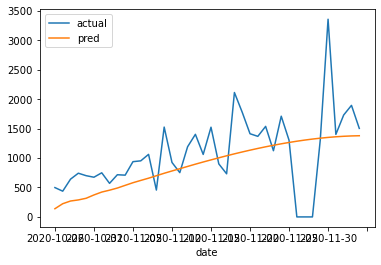

In [21]:

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

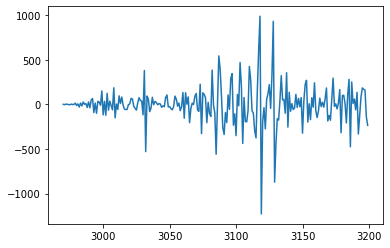

In [22]:
plt.plot(model.resid)

In [23]:
harris = data[data['entity'] == 'Texas-Harris'].loc[:, ['date', 'incremental_cases']]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# Harris data is non-stationary without any differencing
stationary_test(harris.incremental_cases)

# test statistic (hypothesis that non-stationarity cannot be rejected)
# p-value is greater than 0.05 

(-2.395824720160588, 0.142918320064836)

In [24]:
# first-level differencing
harris['incremental_cases'] = harris['incremental_cases'].diff().fillna(harris['incremental_cases']).astype('int')

# la is still non-stationary after first-level differencing
stationary_test(harris.incremental_cases)

# test statistic (hypothesis that non-stationarity can be rejected)
# p-value is much less than 0.05

(-9.396340262942193, 6.359410189896808e-16)

In [25]:
train2  = harris.iloc[:230, :]

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

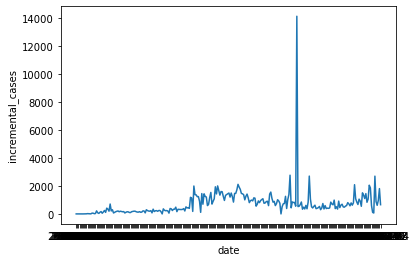

In [27]:
# use non-differenced cases for test actuals
testing2 = data[data['entity'] == 'Texas-Harris'].loc[:, ['date', 'incremental_cases']]
test2 = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [29]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

3170014.9046729784 for parameters (0, 0, 0)
47945194.187448576 for parameters (0, 0, 1)
40908424.44737697 for parameters (0, 0, 5)
54479907811.94998 for parameters (0, 1, 0)
3178847.54690139 for parameters (0, 1, 1)
29786826.008350767 for parameters (0, 1, 5)
20780325381010.2 for parameters (0, 2, 0)
60187777115.759155 for parameters (0, 2, 1)
125902426.04554662 for parameters (0, 2, 5)
1.6046257705599769e+19 for parameters (0, 5, 0)
4.521952730267336e+17 for parameters (0, 5, 1)
4583713396137.85 for parameters (0, 5, 5)
10450529.357052112 for parameters (1, 0, 0)
45078822.09434605 for parameters (1, 0, 1)
92580090.15022711 for parameters (1, 0, 5)
7407373714.454381 for parameters (1, 1, 0)
12761409.07784791 for parameters (1, 1, 1)
6542556.026172217 for parameters (1, 1, 5)
3358999691601.954 for parameters (1, 2, 0)
8250007461.071863 for parameters (1, 2, 1)
964925.6318564771 for parameters (1, 2, 5)
2.1965005288877687e+19 for parameters (1, 5, 0)
1.8994616581035018e+17 for parameters

In [30]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

3170014.9046729784 for parameters (0, 0, 0)
47945194.187448576 for parameters (0, 0, 1)
41424229.41258921 for parameters (0, 0, 3)
40908424.44737697 for parameters (0, 0, 5)
22594468.03884239 for parameters (0, 0, 6)
46615008.87503549 for parameters (0, 0, 7)
63365305.575023726 for parameters (0, 0, 8)
54479907811.94998 for parameters (0, 1, 0)
3178847.54690139 for parameters (0, 1, 1)
35867389.44724147 for parameters (0, 1, 3)
29786826.008350767 for parameters (0, 1, 5)
30036477.55127866 for parameters (0, 1, 6)
12629463.014346365 for parameters (0, 1, 7)
29928438.297045268 for parameters (0, 1, 8)
20780325381010.2 for parameters (0, 2, 0)
60187777115.759155 for parameters (0, 2, 1)
32700498.559336066 for parameters (0, 2, 3)
125902426.04554662 for parameters (0, 2, 5)
4581376.87347653 for parameters (0, 2, 6)
180826380.20458153 for parameters (0, 2, 7)
28934530.177509554 for parameters (0, 2, 8)
4053133330618877.0 for parameters (0, 3, 0)
22447942959362.78 for parameters (0, 3, 1)
77

322187511668.50476 for parameters (4, 3, 1)
3891944057.0736823 for parameters (4, 3, 3)
378271615.84725106 for parameters (4, 3, 5)
7763595251.03342 for parameters (4, 3, 6)
565244404.8399056 for parameters (4, 3, 7)
112327226.52213927 for parameters (4, 3, 8)
715716858805549.4 for parameters (4, 4, 0)
20310862122347.1 for parameters (4, 4, 1)
553341712668.732 for parameters (4, 4, 3)
76777023289.66443 for parameters (4, 4, 5)
58515898707.2278 for parameters (4, 4, 6)
65187560055.03092 for parameters (4, 4, 7)
70376528514.62782 for parameters (4, 4, 8)
1.0359943121222811e+17 for parameters (4, 5, 0)
1116473474261965.0 for parameters (4, 5, 1)
9366889035232.604 for parameters (4, 5, 3)
5467551.15 for parameters (4, 5, 5)
2635442303142.559 for parameters (4, 5, 6)
582878110501.5305 for parameters (4, 5, 7)
5117202407840.664 for parameters (4, 5, 8)
26640520.608360957 for parameters (5, 0, 0)
26953547.414434135 for parameters (5, 0, 1)
20620179.914510947 for parameters (5, 0, 3)
24131565.

In [31]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

6542556.026172217 for parameters (1, 1, 5)
26643282.789948042 for parameters (1, 1, 6)
30739893.391731214 for parameters (1, 1, 7)
964925.6318564771 for parameters (1, 2, 5)
2353073.287141867 for parameters (1, 2, 6)
14344941.52879337 for parameters (1, 2, 7)
338819953.57025206 for parameters (1, 3, 5)
2191341189.51371 for parameters (1, 3, 6)
3699508639.40605 for parameters (1, 3, 7)
2097637.465764596 for parameters (5, 1, 5)
1468268.2566726871 for parameters (5, 1, 6)
4256878.195865545 for parameters (5, 1, 7)
153051231.09726125 for parameters (5, 2, 5)
504450.8493795354 for parameters (5, 2, 6)
96724883.78932211 for parameters (5, 2, 7)
502867809.0211797 for parameters (5, 3, 5)
967116332.7767906 for parameters (5, 3, 6)
707974375.646447 for parameters (5, 3, 7)
1232362.6247790945 for parameters (6, 1, 5)
1033637.1108401468 for parameters (6, 1, 6)
398468.96665272024 for parameters (6, 1, 7)
39769761.32870388 for parameters (6, 2, 5)
11170473.406527251 for parameters (6, 2, 6)
11645

In [41]:
model2 = ARIMA(train2.incremental_cases, order=(6, 1, 7)).fit()
pred = pd.concat([pd.Series([-62]), model2.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test2.incremental_cases, pred)
r2

-0.3269482779639339

<AxesSubplot:xlabel='date'>

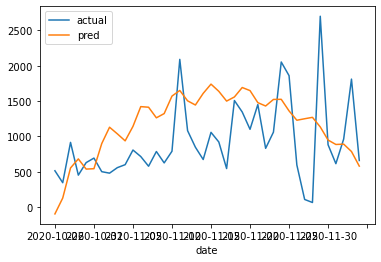

In [42]:
prediction = pd.DataFrame({'actual':test2.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test2['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [43]:
philly= data[data['entity'] == 'Pennsylvania-Philadelphia'].loc[:, ['date', 'incremental_cases']]

In [44]:
stationary_test(philly.incremental_cases)

(-0.3535586053857135, 0.9175688476501691)

In [46]:
philly['incremental_cases'] = philly['incremental_cases'].diff().fillna(philly['incremental_cases']).astype('int')
stationary_test(philly.incremental_cases)


(-3.985676159805606, 0.001487400482092525)

<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

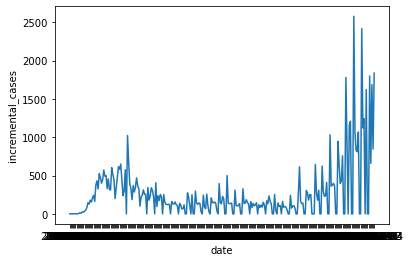

In [47]:
# use non-differenced cases for test actuals
# using differenced cases for train
train = philly.iloc[:230, :]
testing = data[data['entity'] == 'Pennsylvania-Philadelphia'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [48]:
p_values = [1, 5, 10]
d_values = [1, 2, 4, 6]
q_values = [1, 5, 10, 15]
vals = []
prev = 100000000000000000000000000
for p in p_values:
    for d in d_values:
        for q in q_values:
            param = (p, d, q)
            model = ARIMA(train.incremental_cases, order=param).fit()
            pred = model.forecast(steps=40)
            mse = mean_squared_error(test.incremental_cases, pred)
            if mse < prev:
                prev = mse
                best = param
            print(mse, 'for parameters', param)
print(best, prev)

1070184.2413294856 for parameters (1, 1, 1)
1059111.7801579311 for parameters (1, 1, 5)
1054435.0563171352 for parameters (1, 1, 10)
1047336.2344121117 for parameters (1, 1, 15)
1366245.9295804729 for parameters (1, 2, 1)
1077303.2982724821 for parameters (1, 2, 5)
1064782.6743722397 for parameters (1, 2, 10)
1083286.0310691658 for parameters (1, 2, 15)
9547097274.85312 for parameters (1, 4, 1)
3100824.5944267856 for parameters (1, 4, 5)
2583635.6356292414 for parameters (1, 4, 10)
4732898.309873216 for parameters (1, 4, 15)
2093383948172623.2 for parameters (1, 6, 1)
8726791939.678814 for parameters (1, 6, 5)
864780045.1052262 for parameters (1, 6, 10)
5800451337.936434 for parameters (1, 6, 15)
1062279.1252902322 for parameters (5, 1, 1)
996859.0316429269 for parameters (5, 1, 5)
980608.9312737841 for parameters (5, 1, 10)
962847.516998839 for parameters (5, 1, 15)
1207727.4041171826 for parameters (5, 2, 1)
1080095.4484063606 for parameters (5, 2, 5)
1009095.8219985428 for parameter

In [52]:

model = ARIMA(train.incremental_cases, order=(5, 1, 15)).fit()
pred = pd.concat([pd.Series([-62]), model.forecast(steps=40)]).cumsum()[1:]
pred = pd.concat([pd.Series([101]), pred]).cumsum()[1:]
r2 = r2_score(test.incremental_cases, pred)
r2


-21.95668648993384

<AxesSubplot:xlabel='date'>

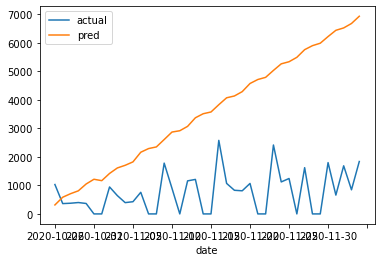

In [53]:
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])